In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('iter.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGCCGACCTCGGAATGCGGTCTCCATGCGGTTT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAAGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCACCTTCAAGAGG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTATCATCCGTCGCTGAGCGCATTTTGT...
...,...,...
4995,ACTACATTTGCCAACTGCCGGCTTGATTGAACAAGAGGCTTGAGCG...,ACTACATTTGCCAACTGCCGGCTTGATTGAACAAGAGGCTTGAGCG...
4996,CGGCGCCCGTGTTTTAGATTATTATACGTTCTTGTACGATCAATAT...,CGGCGCCCGTGTTTTAGATTATTATACGTTCTTGTACGATCAATAT...
4997,CGTAACGCTTATACATCGTAGGAAAGGACCCCTACATTGGATCTAG...,CGTAACGCTTATACATCGTAGGAAAGGACCCCTACATTGGATCTAG...
4998,GGTAAGTGGGCCTGTACATTCACTCTACGGCCCTGAGACGCCTAAT...,GGTAAGTGGGCCTGTACATTCACTCTACGGCCCTGAGACGCCTAAT...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 5000/5000 [00:00<00:00, 51956.13it/s]


[19, 53, 117, 193, 231, 288, 354, 378, 444, 499, 549, 584, 653, 711, 710, 767, 801, 821, 906, 896, 955, 993, 1003, 1084, 1035, 1093, 1123, 1169, 1164, 1205, 1258, 1296, 1302, 1350, 1371, 1416, 1425, 1466, 1462, 1497, 1508, 1520, 1549, 1567, 1581, 1608, 1629, 1607, 1647, 1691, 1676, 1705, 1694, 1690, 1726, 1765, 1723, 1750, 1756, 1791, 1783, 1782, 1767, 1823, 1797, 1816, 1797, 1854, 1830, 1859, 1868, 1875, 1877, 1889, 1932, 1904, 1887, 1942, 1955, 1953, 1926, 1949, 1953, 1953, 1950, 1959, 1926, 1993, 1972, 2002, 1953, 1957, 1947, 1992, 1912, 1936, 1931, 1947, 1889, 1960, 1924, 1979, 2022, 1960, 1947, 1983, 2014, 1959, 1957, 1965]


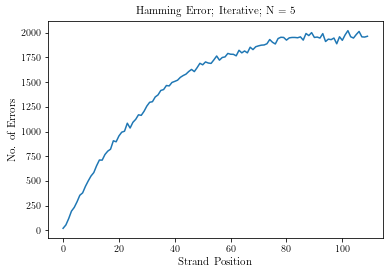

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 5000/5000 [00:06<00:00, 764.91it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> GA 6
AA ->  6
 -> TG 7
 -> GT 7
 -> CG 7
TA ->  8
CT ->  9
GA ->  9
CA ->  10
 -> GC 10
 -> TA 10
GT ->  11
TG ->  12
AT ->  12
TC ->  13
AC ->  13
AG ->  15
CG ->  16
G -> A 31
G -> C 47
G -> T 48
T -> A 49
C -> G 54
A -> T 55
A -> C 60
C -> A 60
T -> C 62
A -> G 64
T -> G 67
C -> T 84
G ->  484
A ->  531
T ->  607
C ->  610
 -> A 613
 -> T 652
 -> C 683
 -> G 715


G ->  @ 17 6
 -> C @ 82 6
 -> T @ 105 6
T ->  @ 101 6
 -> C @ 8 6
 -> C @ 93 6
 -> T @ 109 6
 -> C @ 85 6
 -> T @ 106 6
T ->  @ 105 6
 -> C @ 87 6
T ->  @ 106 6
 -> C @ 88 6
 -> C @ 89 6
 -> T @ 15 6
 -> C @ 74 6
A ->  @ 19 6
 -> A @ 32 6
T ->  @ 61 6
 -> T @ 68 6
T ->  @ 74 6
 -> C @ 40 6
 -> T @ 50 6
 -> T @ 73 6
G ->  @ 10 6
 -> A @ 11 6
T ->  @ 8 6
 -> T @ 47 6
 -> A @ 14 6
 -> A @ 17 6
 -> T @ 4 6
G ->  @ 16 6
T ->  @ 9 6
T ->  @ 93 6
 -> A @ 2 6
T ->  @ 50 6
 -> T @ 99 6
T ->  @ 46 6
T ->  @ 44 6
 -> G @ 97 6
 -> A @ 26 6
 -> C @ 58 6
T ->  @ 4 6
 -> C @ 60 6
 -> C @ 69 6
T ->  @ 30 6
T ->  @ 90 6
C ->  @ 88 6
T ->  @ 63 6
 -> G @ 93 6
C ->  @ 21 6
G ->  @ 85 6
 -> G @ 22 6
C ->  @ 27 6
C ->  @ 29 6
C ->  @ 33 6
 -> G @ 32 6
 -> G @ 19 6
A ->  @ 77 6
C ->  @ 4 6
C ->  @ 85 6
 -> G @ 41 6
 -> A @ 94 6
 -> G @ 43 6
 -> G @ 49 6
A ->  @ 84 6
 -> A @ 97 6
 -> G @ 18 6
G ->  @ 80 6
G ->  @ 49 6
A ->  @ 22 6
A ->  @ 14 6
G ->  @ 64 6
G ->  @ 6 6
A ->  @ 31 6
A ->  @ 38 6
A ->  @ 39 6
A

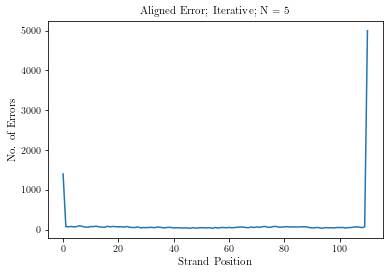

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[13, 4, 10, 9, 4, 7, 10, 9, 5, 2, 7, 7, 10, 7, 3, 8, 5, 9, 6, 6, 8, 7, 6, 11, 1, 5, 7, 9, 3, 3, 4, 3, 6, 4, 9, 5, 4, 5, 5, 5, 1, 6, 8, 6, 5, 8, 8, 7, 3, 6, 3, 7, 4, 8, 4, 7, 2, 5, 6, 4, 8, 6, 2, 5, 11, 12, 4, 4, 8, 8, 6, 6, 12, 10, 5, 6, 8, 8, 9, 12, 8, 9, 10, 5, 10, 7, 11, 7, 11, 8, 7, 4, 5, 6, 2, 7, 5, 6, 3, 4, 5, 4, 8, 6, 10, 8, 9, 7, 4, 10, 0]
[9, 8, 7, 7, 7, 9, 5, 5, 6, 4, 10, 6, 11, 2, 5, 6, 6, 5, 4, 7, 4, 8, 4, 14, 7, 3, 6, 2, 5, 9, 4, 5, 7, 7, 7, 5, 7, 7, 3, 3, 6, 8, 2, 2, 2, 8, 2, 8, 5, 4, 7, 3, 4, 3, 7, 3, 4, 11, 6, 5, 6, 2, 8, 9, 4, 9, 10, 10, 11, 6, 11, 8, 9, 12, 6, 4, 5, 10, 3, 3, 8, 8, 6, 13, 7, 6, 7, 6, 6, 6, 3, 7, 3, 6, 5, 7, 5, 8, 3, 7, 7, 3, 5, 4, 2, 8, 5, 5, 12, 13, 0]
[1, 5, 4, 4, 6, 3, 5, 10, 8, 4, 4, 4, 7, 9, 5, 6, 7, 4, 10, 4, 5, 7, 7, 5, 8, 2, 5, 12, 5, 5, 4, 9, 1, 1, 9, 10, 8, 4, 9, 9, 7, 7, 2, 9, 3, 3, 4, 6, 5, 2, 6, 3, 4, 5, 1, 5, 4, 8, 5, 7, 9, 6, 7, 9, 5, 13, 10, 5, 6, 1, 7, 5, 10, 6, 5, 10, 7, 7, 7, 5, 11, 9, 7, 2, 5, 9, 8, 3, 5, 3, 4, 5, 7, 5, 7, 4, 2, 5,

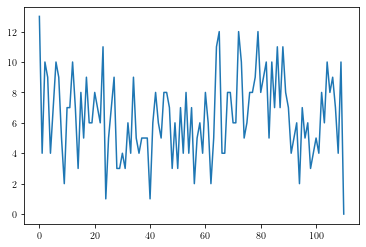

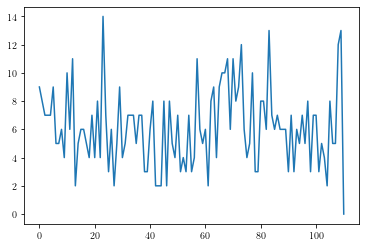

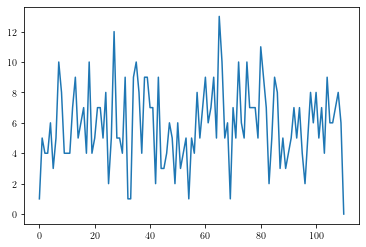

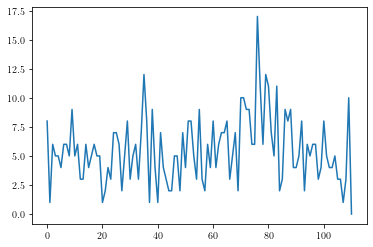

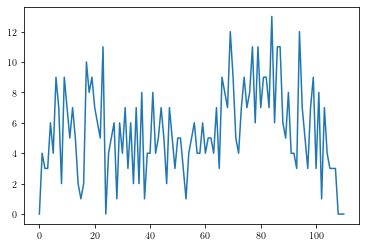

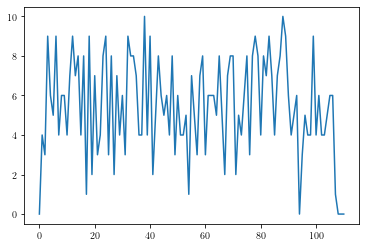

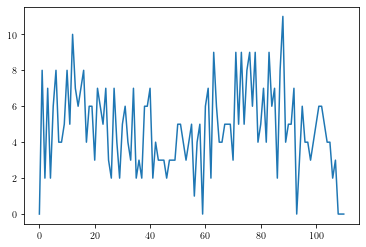

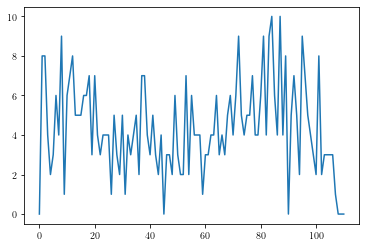

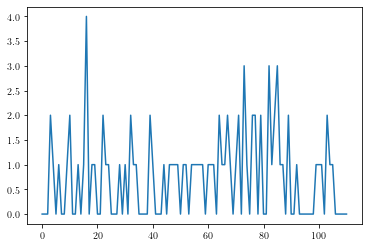

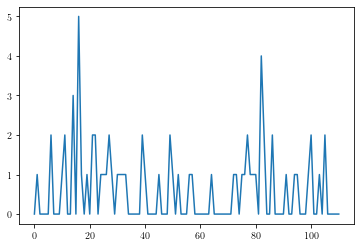

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)